In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import os, sys
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from pandas import DataFrame
import torch, torch.nn as nn
import numpy as np
import random
import networkx as nx
from utils_mcts import ReplayBuffer, PathsBuffer, get_states_emb, convert_to_walk, is_valid_path_new
from MCTS_Act_LSTM import MCTS
from problem_mcts import GraphProblem, generate_erdos_renyi_problems, generate_regular_problems
from network_mcts import AgentActLSTM, AgentAct
import time
import nn_utils
from collections import defaultdict as ddict

In [4]:
sys.path.insert(0, '..')
moving_average = lambda x, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

In [5]:
def replace(P, source, target):
    '''Replace last occurrence of source with source-target-source.'''
    assert source in P
    ix = len(P) - P[::-1].index(source)
    return P[:ix] + [target, P[ix - 1]] + P[ix:]

In [6]:
def covering_walk(graph, source):
    P = [0]  # supporting walk
    S = [0]  # stack of nodes to check
    node2anon = {source: 0}
    anon2node = {0: source}
    checked = dict()  # nodes that has been checked for edge
    degrees = graph.degree()
    while len(S) > 0:  # grow supporting walk in DFS manner
        curr = S[-1]
        x = max(P) + 1  # next node to check

        # check if there is a node in the neighborhood that has not been explored yet
        Ncurr = list(nx.neighbors(graph, anon2node[curr]))
        if random.uniform(0, 1) < 0.99:
            random.shuffle(Ncurr)  # option 1: random order
        else:
            Ncurr = sorted(Ncurr, key=lambda v: degrees[v], reverse=True)  # option 2: top-degree
            # Ncurr = sorted(Ncurr, key=lambda v: degrees[v], reverse=False)  # option 3: low-degree
        # print(anon2node[curr], Ncurr)
        for neighbor in Ncurr:
            if neighbor in node2anon:
                continue  # already visited
            else:
                node2anon[neighbor] = x
                anon2node[x] = neighbor
                S.append(x)
                checked.setdefault(curr, set()).add(x)
                P = replace(P, curr, x)  # move to it
                break
        else:
            S.pop()  # move back in the stack

        for u in range(x-1, curr, -1):  # u is already in the supporting walk
            # check if there is connection to already discovered nodes
            if u not in checked[curr]:  # see if we already checked this edge
                if anon2node[u] in graph[anon2node[curr]]:
                    P = replace(P, curr, u)
                checked.setdefault(curr, set()).add(u)

    cover = [anon2node[v] for v in P]
    return cover, P

In [7]:
#params
NUM_PROBLEMS = 10
NUM_EPISODES = 10
BATCH_SIZE = 32
NUM_MCSIMS = 5
NUM_UPDATES = 5
NUM_VERTICES = 15
DEGREE = 6
CPUCT = 1.0
THRESHOLD = 0.75
PATHS_BUFFER_CAPACITY = 1000
REPLAY_BUFFER_CAPACITY = 10000

In [8]:
moving_average = lambda x, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

In [9]:
#generate regular train graphs (n=15, d=6)
problem_maker = generate_regular_problems(num_vertices=NUM_VERTICES, degree=DEGREE)

In [10]:
#initialize agent
agent = AgentAct(hid_size=256, gcn_size=256, vertex_emb_size=64)

In [11]:
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-4)

In [12]:
#initialize buffers
path_buffer = PathsBuffer(capacity=PATHS_BUFFER_CAPACITY, threshold=THRESHOLD)
train_buffer = ReplayBuffer(capacity=REPLAY_BUFFER_CAPACITY)

In [13]:
# loss stats
pi_losses_history = []
v_losses_history = []

In [14]:
problems = [next(problem_maker) for i in range(NUM_PROBLEMS)]

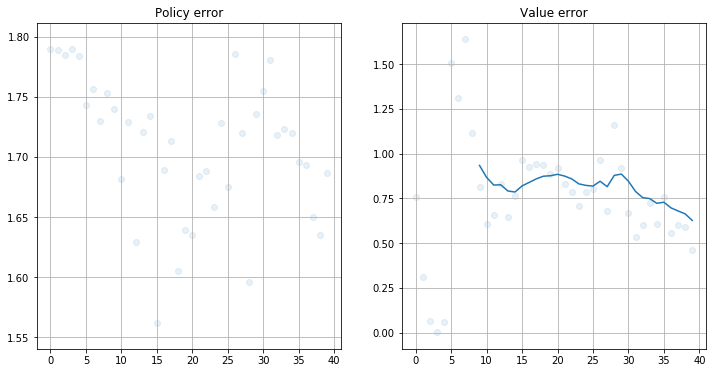

In [ ]:
i = 0

for k in trange(len(problems)):
    
    problem = problems[k]
    
    edges = problem.get_edges()

    for vertex in problem.get_actions():

        path_buffer.flush()
    
        PATH_LENGTH = 2*problem.num_edges + 1        
        
        i += 1
    
        for episode in range(NUM_EPISODES):
            
            problem.path = [vertex]
        
            source = problem.get_state()[0]
            
            states = []
            actions = []
            
            with torch.no_grad():
                graph_emb = agent.embed_graph(problem.edges)
                
            mcts = MCTS(game=problem, nnet=agent, graph_emb=graph_emb,
                        numMCTSSims=NUM_MCSIMS, cpuct=CPUCT, edges=edges)
            
            trainExamples = []
                
            random_walk = [source]
            checked = ddict(list)
            stack = [source]
            visited = {source}
            ranks = {0: source} # to attempt to get maximal cover (possible to do without rank, but then no guarantees on maximality)
            revranks = {source: 0}
            
            while len(stack) > 0:
                last = stack[-1]
                lastrank = revranks[last]
                maxrank = max(ranks.keys()) + 1
                with torch.no_grad():
                    pi = mcts.getActionProb(random_walk, path_buffer)
                Nlast = [x for _,x in sorted(zip(pi, edges[random_walk[:][-1]]), reverse=True)]
                #print("Is valid", all(i in edges[random_walk[:][-1]] for i in Nlast))
                # going in depth
                flag = False
                for neighbor in Nlast:
                    if neighbor not in visited:
                        trainExamples.append([random_walk, pi, None])
                        random_walk.append(neighbor)
                        stack.append(neighbor)
                        checked[last].append(neighbor)
                        visited.add(neighbor)
                        ranks[maxrank] = neighbor
                        revranks[neighbor] = maxrank
                        flag = True
                        break

                # interconnecting nodes that are already in walk
                if not flag:
                    for r in range(maxrank-1, lastrank+1, -1):
                        node = ranks[r]
                        if node not in checked[last] and node in Nlast:
                            checked[last].append(node)
                            random_walk.extend([node, last])

                if not flag:
                    stack.pop()
                    if len(stack) > 0:
                        random_walk.append(stack[-1])
                        checked[last].append(stack[-1])
                        
            path_buffer.push(random_walk)
            if len(path_buffer) >= 10: 
                r = path_buffer.rank_path(random_walk)
                for x in trainExamples:
                    x[-1] = r
                train_buffer.push(trainExamples)
            
        if len(train_buffer) >= BATCH_SIZE:
            print("Start training!")
            for i in range(NUM_UPDATES):
                batch = train_buffer.sample(BATCH_SIZE)
                paths, pis, vs = zip(*batch)
                graph_emb = agent.embed_graph(problem.edges)
                out_pi, out_v = agent.get_dist(paths, graph_emb, edges)
                
                target_vs = torch.tensor(vs)
                
                losses_pi = []
                for i, p in enumerate(pis):
                    losses_pi.append(torch.tensor(p)*torch.log(out_pi[i]))
            
                loss_pi = -torch.sum(torch.stack(losses_pi))/len(pis)
                loss_v = torch.sum((target_vs-out_v.view(-1))**2)/target_vs.size()[0]
                total_loss = loss_pi + loss_v

                pi_losses_history.append(loss_pi.item())
                v_losses_history.append(loss_v.item())

                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

                clear_output(True)
                plt.figure(figsize=[12, 6])
                plt.subplot(1,2,1)
                plt.title('Policy error'); plt.grid()
                plt.scatter(np.arange(len(pi_losses_history)), pi_losses_history, alpha=0.1)
                plt.plot(moving_average(pi_losses_history, span=100, min_periods=100))

                plt.subplot(1,2,2)
                plt.title('Value error'); plt.grid()
                plt.scatter(np.arange(len(v_losses_history)), v_losses_history, alpha=0.1)
                plt.plot(moving_average(v_losses_history, span=10, min_periods=10))
                plt.show()

In [ ]:
path = [[0, 13, 14, 11, 4, 8, 6, 10, 3, 7, 5, 7, 3, 10, 2, 10, 12, 1, 12, 10, 7, 10, 6, 12, 6, 3, 6, 8, 9, 8, 2, 8, 4, 2, 4, 5, 4, 7, 4, 6, 4, 11, 2, 11, 10, 11, 14, 2, 14, 5, 14, 8, 14, 4, 14, 13, 1, 13, 3, 13, 6, 13, 8, 13, 4, 13, 0, 9, 0, 1, 0, 3, 0, 10, 0]]

In [ ]:
edges

In [ ]:
agent.get_dist(path, graph_emb, edges)

In [ ]:
np.log([0.1835, 0.2127, 0.1741, 0.2131, 0.2166])

In [ ]:
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

In [ ]:
p = next(problem_maker)

In [ ]:
p.path = [random.sample(list(p.edges.keys()), 1)[0]]

In [ ]:
graph_emb = agent.embed_graph(p.edges)
path_length = 2*p.num_edges+1
mcts = MCTS(game=p, nnet=agent, graph_emb=graph_emb,
                    numMCTSSims=NUM_MCSIMS, cpuct=CPUCT, path_length=path_length)
path = p.get_state()
while len(path) != path_length:
    with torch.no_grad():
        pi = mcts.getActionProb(path)
    vertex = np.random.choice(len(pi), p=pi)
    path = p.get_next_state(path, vertex)
print(path)

In [ ]:
np.argsort([1, 5, 3])

In [ ]:
graph_emb = agent.embed_graph(p.edges)

In [ ]:
lstm = nn.LSTM(256, hidden_size= 256, batch_first=True)

In [ ]:
print(lstm)

In [ ]:
x = [3, 5, 6, 7, 8]

In [ ]:
l = []
for i in x:
    l.append(graph_emb[i])

In [ ]:
l

In [ ]:
l = torch.stack(l).unsqueeze(0)

In [ ]:
l

In [ ]:
out, hidden = lstm(l)

In [ ]:
print(hidden)

In [ ]:
k = hidden[-1].view(-1)

In [ ]:
k

In [ ]:
walk_embs

In [ ]:
walk_embs, hidden = lstm(l)

In [ ]:
hidden

In [ ]:
hn[:, -1, :][-1]

In [ ]:
f = torch.tensor([[2., 5., 6.]])

In [ ]:
torch.cat((walk_embs[:, -1, :], f), 1)

In [ ]:
hn.view(-1, -1, -1)

In [ ]:
linear = nn.Linear(10, 1)

In [ ]:
y = linear(walk_embs[:, -1, :])

In [ ]:
y

In [ ]:
embs = y[0]

In [ ]:
embs

In [ ]:
embs[len([3, 5, 6, 7, 8])]

In [ ]:
inputs = [torch.randn(1, 3) for _ in range(5)]

In [ ]:
inputs

In [ ]:
torch.cat(inputs).view(len(inputs), 1, -1)

In [ ]:
p.edges

In [ ]:
paths = [[2, 7, 5, 9], [2, 7, 5, 9, 8]]

In [ ]:
graph_emb = agent.embed_graph(p.edges)

In [ ]:
paths_emb = get_states_emb(paths, graph_emb)

In [ ]:
paths_emb.shape

In [ ]:
next_emb = graph_emb[8]

In [ ]:
next_emb = next_emb.unsqueeze(0)

In [ ]:
q_network_inputs = torch.stack([
torch.cat([get_states_emb([path], graph_emb), graph_emb[next_vertex].unsqueeze(0)] for next_vertex in {2, 5, 8}]
            )])

In [ ]:
[torch.cat([get_states_emb([path], graph_emb), graph_emb[next_vertex].unsqueeze(0)]) for next_vertex in {2, 5, 8}]

In [ ]:
for next_vertex in {2, 5, 8}:
    print(torch.cat([get_states_emb([path], graph_emb), graph_emb[next_vertex].unsqueeze(0)], 1))

In [ ]:
paths_emb

In [ ]:
[torch.cat([get_states_emb(paths, graph_emb), graph_emb[next_vertex].unsqueeze(0)]) for next_vertex in {2, 5, 8}]

In [ ]:
x = get_states_emb([[1,2,3]], graph_emb)

In [ ]:
for i in x:
    print(torch.cat([i, next_emb]).shape)

In [ ]:
paths_embs = get_states_emb(paths, graph_emb)

In [ ]:
values = agent.value(paths_emb)

In [ ]:
values

In [ ]:
states = []
for i, path in enumerate(paths):
    next_embs = []
    for next_vertex in p.edges[path[-1]]:
        next_vertex_emb = graph_emb[next_vertex]
        next_embs.append(torch.cat([paths_embs[i], next_vertex_emb]))
    states.append(torch.stack(next_embs))
print(states)
predicts = []
for i in states:
    predicts.append(sm(log_reg(i)).view(-1))

In [ ]:
predicts

In [ ]:
log_reg = nn.Linear(768, 1)

In [ ]:
sm = nn.Softmax(dim=0)

In [ ]:
torch.states.unsqueeze(0)

In [ ]:
p.edges

In [ ]:
len(states[0][0])

In [ ]:
random.sample([1, -1], 1)[0]